In [1]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
from data_processing_xu import get_data_2dprojection
import os
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
from pyproj import Proj, transform
from tqdm import tqdm_notebook
EPS = 1e-7

def lat(x,y,z):
    return np.arcsin(z/np.sqrt(x**2 + y**2 + z**2))

def lon(x,y,z):
    return np.arctan2(y,x)


def get_data_2dprojection_stereo(lpmt_hits, spmt_hits, pos, true_info, edge_size1=110, edge_size2=110, use_spmt=False, time=None):
    """
    Transfer data into 2d projection (moll) with 1 channel
    Params:
    ..., 
    edge_size : int - projection image size, 
    use_spmt : bool 
    
    Returns:
    data_lpmt: pd.DataFrame
    event_to_id: dict
    """
    channels = 1
    if time == 'min':
        channels = 2
        
    pos['lat'] = list(map(lambda el: lat(el[0],el[1],el[2]), zip(pos['pmt_x'], pos['pmt_y'], pos['pmt_z'])))
    pos['lon'] = list(map(lambda el: lon(el[0],el[1],el[2]), zip(pos['pmt_x'], pos['pmt_y'], pos['pmt_z'])))
    p1 = Proj(proj='latlong')
    p2 = Proj(proj='stere')
    pos['mol0'] = list(map(lambda el: transform(p1,p2,el[0],el[1])[0], zip(pos['lat'], pos['lon'])))
    pos['mol1'] = list(map(lambda el: transform(p1,p2,el[0],el[1])[1], zip(pos['lat'], pos['lon'])))
    
    print("Make projection")
    if use_spmt:
        lpmt_hits = pd.concat([lpmt_hits, spmt_hits])
    merged_hits = pd.merge(lpmt_hits, pos, left_on='pmtID', right_on='pmt_id')
    EPS = 1e-7
    mol0min = -175000
    mol0max = 175000
    mol1min = -350000
    mol1max = 350000
    # Fit coordinates
    merged_hits['mol0i'] = round((merged_hits['mol0'] - mol0min) / (mol0max - mol0min) * (edge_size1 - 1)).astype(int)
    merged_hits['mol1i'] = round((merged_hits['mol1'] - mol1min) / (mol1max - mol1min) * (edge_size2 - 1)).astype(int)
    
    n = len(lpmt_hits['event'].unique())
    data_lpmt = np.zeros((n, edge_size1, edge_size2, channels))
    
    event_to_id = {x:y for y, x in enumerate(sorted(merged_hits['event'].unique()))}
    print("Starting cycle...")
    if time is None:
        for event, mol0i, mol1i in tqdm_notebook(zip(merged_hits['event'], merged_hits['mol0i'], merged_hits['mol1i'])):
            data_lpmt[event_to_id[event]][mol0i, mol1i] += 1
    elif time == 'min':
        data_lpmt[:,:,:,1] = -EPS
        # Calculate min time for each event
        ev_min = merged_hits[['event', 'hitTime']].groupby('event').min()
        event2min = {id_: min_ for id_, min_ in zip(ev_min.index, ev_min.hitTime)}
        ev_len = merged_hits[['event', 'hitTime']].groupby('event').count()
        event2len = {id_: len_ for id_, len_ in zip(ev_len.index, ev_len.hitTime)}
        
        for event, mol0i, mol1i, time in tqdm_notebook(zip(merged_hits['event'], merged_hits['mol0i'], merged_hits['mol1i'], merged_hits['hitTime'])):
            event_id = event_to_id[event]
            data_lpmt[event_id][mol0i, mol1i][0] += 1 * 1000 / event2len[event]
            event_min = event2min[event]
            cur_min = data_lpmt[event_id][mol0i, mol1i][1] 
            if cur_min < 0 or cur_min > (time/100 - event_min/100):
                data_lpmt[event_id][mol0i, mol1i][1] = (time - event_min)/100
    return data_lpmt, event_to_id


In [3]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
#TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
TRAIN_DIR = '~/data/data_dir/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r') 
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'lpmt_pos.csv') 
tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv') 
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [4]:
MAXR=17200

In [5]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'

In [6]:
rg = np.arange(0,100000,15000)

In [7]:
rg = rg[:3]

In [9]:
for start, end  in zip(rg[:-1], rg[1:]):
    data_lpmt, event_to_id = get_data_2dprojection_stereo(tr_lpmt_hits[(tr_lpmt_hits['event'] >= start) & (tr_lpmt_hits['event'] < end)
                                                                & (tr_lpmt_hits['isDN'] == False)], 
                                                tr_spmt_hits[(tr_spmt_hits['event'] >= start) & (tr_spmt_hits['event'] < end) 
                                                            & (tr_spmt_hits['isDN'] == False)], 
                                                tr_pos, 
                                                tr_true_info[(tr_true_info.R<=MAXR) 
                                                             & (tr_true_info['evtID'] >= start) 
                                                             & (tr_true_info['evtID'] < end)],
                                                use_spmt=False,
                                                time='min')
    np.save(LTRAIN + '1_' + str(start) + 'without_noise' + '_time_min_xu_stereo', data_lpmt)

Make projection
Starting cycle...



Make projection
Starting cycle...


In [1]:
fig = plt.figure(figsize=(10,8))
plt.imshow(data_lpmt[0][:,:,1])

NameError: name 'plt' is not defined

In [22]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [23]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [24]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [25]:
import keras
import keras.layers as L
from keras.models import Sequential

Using TensorFlow backend.


In [26]:
model = Sequential()
model.add(L.Conv2D(filters=32, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.Flatten())
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(1))

In [27]:
from keras.optimizers import Adam
opt = Adam(decay=1e-4)
model.compile(loss='mean_squared_error', optimizer=opt)
model.build(input_shape=(None, 111,226,2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 109, 224, 32)      608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 112, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 110, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 24, 128)       147584    
__________

In [28]:
logdir = 'log_YuXu_stereo.csv'

In [29]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(logdir, append=True, separator=';')

In [30]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [35]:
epochs = [5,5,5,3,3,1,1,1,1,1]

In [36]:
import gc
for i in range(len(epochs)):
    for start, end in zip(rg[:-1], rg[1:]):
        data_lpmt = np.load(LTRAIN + '1_' + str(start) +'without_noise_time_min_xu_stereo'+ '.npy')
        ys = tr_true_info[(tr_true_info['evtID'] >= start) 
                            & (tr_true_info['evtID'] < end)]
        mask = (ys.R <= MAXR)
        data_lpmt = data_lpmt[mask]
        y_val = ys[mask][['E']].values
        
        X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)
        out = model.fit(X_train, y_train, batch_size=32, 
                epochs=epochs[i],
                callbacks=[csv_logger, reduce_lr],
                validation_data=(X_test, y_test),
                shuffle=True)
    gc.collect()

Train on 11020 samples, validate on 2756 samples
Epoch 1/5
11020/11020 [==============================] - 28s 3ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 2/5
11020/11020 [==============================] - 27s 2ms/step - loss: 0.0246 - val_loss: 0.0227
Epoch 3/5
11020/11020 [==============================] - 29s 3ms/step - loss: 0.0231 - val_loss: 0.0242
Epoch 4/5
11020/11020 [==============================] - 30s 3ms/step - loss: 0.0188 - val_loss: 0.0201
Epoch 5/5
11020/11020 [==============================] - 27s 2ms/step - loss: 0.0172 - val_loss: 0.0399
Train on 10988 samples, validate on 2747 samples
Epoch 1/5
10988/10988 [==============================] - 27s 2ms/step - loss: 0.0310 - val_loss: 0.0266
Epoch 2/5
10988/10988 [==============================] - 26s 2ms/step - loss: 0.0218 - val_loss: 0.0188
Epoch 3/5
10988/10988 [==============================] - 26s 2ms/step - loss: 0.0222 - val_loss: 0.0217
Epoch 4/5
10988/10988 [==============================] - 27s 2ms/step 

In [37]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'

In [38]:
MAXR=17200

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
cs = pd.read_csv(logdir, sep=';')

(0, 0.3)

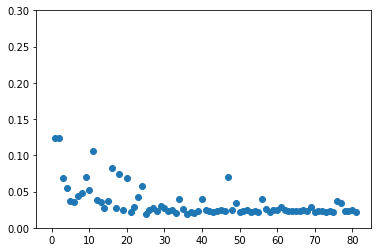

In [41]:
plt.scatter(np.arange(0, cs.shape[0]), cs['val_loss'].values)
plt.ylim(0,0.3)

(0, 0.5)

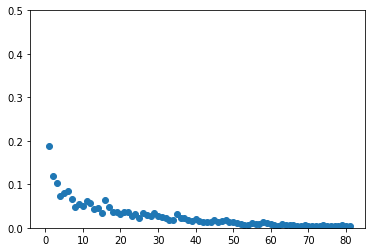

In [42]:
plt.scatter(np.arange(0, cs.shape[0]), cs['loss'].values)
plt.ylim(0,0.5)

In [ ]:
model.save_weights('ResNet70.h5')

In [ ]:
with open("ResNet70.json", "w") as json_file:
    json_file.write(model.to_json())

In [43]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

In [44]:
preds = np.maximum(model.predict(X_test), 0)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])

In [45]:
test_resultsE.mean()

0.022333011232241216

(-0.05, 0.05)

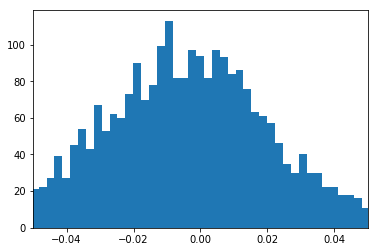

In [46]:
plt.hist((preds[:,0] - y_test[:,0])/y_test[:,0], bins=200)
plt.xlim((-0.05,0.05))

In [47]:
from tqdm import tqdm

In [48]:
root_data_path = '/mnt/iprovilkov/data_dir/0MeV_lpmt_hits.h5'

In [50]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E', MAXR=MAXR, use_spmt=False,
                time=False, recompute=False):
    sigmas = {}
    MSEs = {}
    predictions = {}
    CONST = 1.022
    for energy in tqdm(range(10)):
        try:
            if recompute:
                raise Exception("Recompute")
            if time:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_time_YuXu_stereo.npy')
            else:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_YuXu_stereo.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            print("Compute...")
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            lpmt_hits = lpmt_hits[lpmt_hits.isDN==False]
            spmt_hits = spmt_hits[spmt_hits.isDN==False]
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            if time:
                data_lpmt, event_to_id = get_data_2dprojection_stereo(lpmt_hits, 
                                    spmt_hits, 
                                    pos, 
                                    true_info,
                                    use_spmt=use_spmt,
                                    time='min')
                np.save(test_dir+str(energy)+'data_lpmt_time_YuXu_stereo', data_lpmt)
            else:
                data_lpmt, event_to_id = get_data_2dprojection_stereo(lpmt_hits, 
                                    spmt_hits, 
                                    pos, 
                                    true_info,
                                    use_spmt=True)
                np.save(test_dir+str(energy)+'data_lpmt_YuXu_stereo', data_lpmt)
        mask = (true_info.R<=MAXR)
        data_lpmt = data_lpmt[mask]
        true_info = true_info[mask]
        preds = np.maximum(model.predict(data_lpmt), 0)
        y_test = true_info[test_column]
        print(y_test.mean())
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(preds, y_test)
        # in percents
        sigmas[energy] = np.std(preds - y_test.mean()) / (energy + CONST)
    print("+")
    return sigmas, MSEs, predictions

In [51]:
sigmas, MSEs, predictions = test_sigmas(model, use_spmt=False, time=True, recompute=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Compute...
Make projection
Starting cycle...


 10%|█         | 1/10 [01:02<09:24, 62.70s/it]

0.5109988999999999
Compute...
Make projection
Starting cycle...


 20%|██        | 2/10 [02:18<08:52, 66.62s/it]

1.5109988697622994
Compute...
Make projection
Starting cycle...


 30%|███       | 3/10 [03:46<08:30, 72.94s/it]

2.5109990065502177
Compute...
Make projection
Starting cycle...


 40%|████      | 4/10 [05:26<08:07, 81.29s/it]

3.5109988987951803
Compute...
Make projection
Starting cycle...


 50%|█████     | 5/10 [07:20<07:35, 91.09s/it]

4.510998806956522
Compute...
Make projection
Starting cycle...


 60%|██████    | 6/10 [09:28<06:47, 101.94s/it]

5.510998686870312
Compute...
Make projection
Starting cycle...


 70%|███████   | 7/10 [11:44<05:37, 112.34s/it]

6.510998666593649
Compute...
Make projection
Starting cycle...


 80%|████████  | 8/10 [14:14<04:07, 123.54s/it]

7.510998798899285
Compute...
Make projection
Starting cycle...


 90%|█████████ | 9/10 [16:56<02:15, 135.08s/it]

8.510999212171052
Compute...
Make projection
Starting cycle...


100%|██████████| 10/10 [19:52<00:00, 147.44s/it]

9.510998837121212
+


In [52]:
sigmas, MSEs

({0: 0.034245857403936215,
  1: 0.036477526736424536,
  2: 0.031120616580223418,
  3: 0.030548971707639497,
  4: 0.025261070376038787,
  5: 0.023038484396153767,
  6: 0.025513241074425444,
  7: 0.02148135757244189,
  8: 0.02124000979061799,
  9: 0.02237754598679216},
 {0: 0.005146565949582856,
  1: 0.00594980696786678,
  2: 0.009689756584741653,
  3: 0.01668799767571849,
  4: 0.018017668985589944,
  5: 0.020443515239541653,
  6: 0.032644158361108046,
  7: 0.029724172087741908,
  8: 0.036746143224750435,
  9: 0.050978535986668204})

In [53]:
a = 2.8
b=0.59
c=0


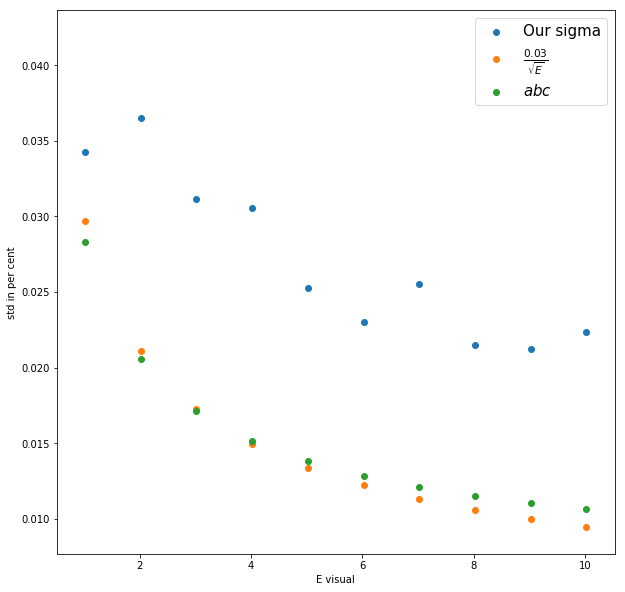

In [54]:
# Plot sigmas
Evis = np.array([en + 1.022  for en in range(10)])
Perc_sigmas = [sigmas[en] for en in range(10)]
perc_3_sqrt_E = [0.03 / np.sqrt(en) for en in Evis]
fig = plt.figure(figsize=(10,10))
plt.scatter(Evis, Perc_sigmas, label='Our sigma')
plt.scatter(Evis, perc_3_sqrt_E, label=r'$\frac{0.03}{\sqrt{E}}$')
plt.scatter(Evis, 0.01*np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2), label=r'$abc$')
plt.ylabel("std in per cent")
plt.xlabel("E visual")
plt.legend(fontsize=15)